# PyTorch Neural Network for Rice Paddy Yield

To address our research question, “Can we accurately predict rice paddy yield from growing conditions, and which model performs best?”, we train and tune a PyTorch regression model on the provided paddyclean training data only (no held-out test set is touched here). 

In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.base import BaseEstimator, RegressorMixin

import matplotlib.pyplot as plt

# Load training data only (held-out test set is not touched here)
train_path = "/Users/oliverandress/Analytics2-Final-1/paddyclean.csv"
data = pd.read_csv(train_path)

# Define features and target
X = data.drop("Paddy yield(in Kg)", axis=1)
y = data["Paddy yield(in Kg)"]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (2789, 44)
y shape: (2789,)


In [15]:
# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object"]).columns

print("Numeric columns:", len(numeric_cols))
print("Categorical columns:", len(categorical_cols))

# Preprocessor
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
    ]
)


Numeric columns: 36
Categorical columns: 8


In [16]:
class TorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        hidden_dim=64,
        hidden_dim2=32,
        lr=1e-3,
        weight_decay=0.0,
        n_epochs=50,
        batch_size=64,
        random_state=42,
    ):
        self.hidden_dim = hidden_dim
        self.hidden_dim2 = hidden_dim2
        self.lr = lr
        self.weight_decay = weight_decay
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.random_state = random_state
        self.model_ = None

    def _set_seed(self):
        torch.manual_seed(self.random_state)
        np.random.seed(self.random_state)

    def _build_model(self, input_dim):
        return nn.Sequential(
            nn.Linear(input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim2),
            nn.ReLU(),
            nn.Linear(self.hidden_dim2, 1),
        )

    def fit(self, X, y):
        # Ensure deterministic behavior per run
        self._set_seed()

        X_arr = np.asarray(X, dtype=np.float32)
        y_arr = np.asarray(y, dtype=np.float32).reshape(-1, 1)

        input_dim = X_arr.shape[1]
        self.model_ = self._build_model(input_dim)
        self.model_.train()

        dataset = TensorDataset(torch.from_numpy(X_arr), torch.from_numpy(y_arr))
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.model_.parameters(), lr=self.lr, weight_decay=self.weight_decay)

        for _ in range(self.n_epochs):
            for xb, yb in loader:
                optimizer.zero_grad()
                preds = self.model_(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()

        return self

    def predict(self, X):
        X_arr = np.asarray(X, dtype=np.float32)
        self.model_.eval()
        with torch.no_grad():
            preds = self.model_(torch.from_numpy(X_arr)).numpy().reshape(-1)
        return preds


In [17]:
nn_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("nn", TorchRegressor())
])


In [18]:
param_grid = {
    "nn__hidden_dim": [32, 64],
    "nn__hidden_dim2": [16, 32],
    "nn__lr": [1e-3, 3e-3],
    "nn__weight_decay": [0.0, 1e-4],
    "nn__n_epochs": [50, 100],
    "nn__batch_size": [64, 128],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

nn_grid = GridSearchCV(
    estimator=nn_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="r2",
    n_jobs=-1,
    verbose=1,
)

# Fit on training data only
nn_grid.fit(X, y)

print("Best parameters:", nn_grid.best_params_)
print("Best CV score (R^2):", nn_grid.best_score_)


Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters: {'nn__batch_size': 64, 'nn__hidden_dim': 64, 'nn__hidden_dim2': 32, 'nn__lr': 0.003, 'nn__n_epochs': 100, 'nn__weight_decay': 0.0}
Best CV score (R^2): 0.9882182955741883


In [19]:
# Inspect best hyperparameters and cross validated performance
print("Best parameters from initial search:")
print(nn_grid.best_params_)
print("Best CV R^2:", nn_grid.best_score_)

# Optional table of all tries
cv_results = pd.DataFrame(nn_grid.cv_results_)
cv_results[["params", "mean_test_score", "std_test_score"]].sort_values(
    "mean_test_score",
    ascending=False
).head(10)


Best parameters from initial search:
{'nn__batch_size': 64, 'nn__hidden_dim': 64, 'nn__hidden_dim2': 32, 'nn__lr': 0.003, 'nn__n_epochs': 100, 'nn__weight_decay': 0.0}
Best CV R^2: 0.9882182955741883


,params,mean_test_score,std_test_score
30,"{'nn__batch_size': 64, 'nn__hidden_dim': 64, '...",0.988218,0.001384
14,"{'nn__batch_size': 64, 'nn__hidden_dim': 32, '...",0.988099,0.002485
31,"{'nn__batch_size': 64, 'nn__hidden_dim': 64, '...",0.988013,0.001051
15,"{'nn__batch_size': 64, 'nn__hidden_dim': 32, '...",0.987792,0.001981
22,"{'nn__batch_size': 64, 'nn__hidden_dim': 64, '...",0.987210,0.000794
23,"{'nn__batch_size': 64, 'nn__hidden_dim': 64, '...",0.987146,0.000754
7,"{'nn__batch_size': 64, 'nn__hidden_dim': 32, '...",0.986024,0.001524
6,"{'nn__batch_size': 64, 'nn__hidden_dim': 32, '...",0.985553,0.001970
63,"{'nn__batch_size': 128, 'nn__hidden_dim': 64, ...",0.985491,0.001835
62,"{'nn__batch_size': 128, 'nn__hidden_dim': 64, ...",0.985358,0.001957


Training R^2: 0.989943265914917
Training MSE: 850836.25
Training MAE: 670.9583129882812


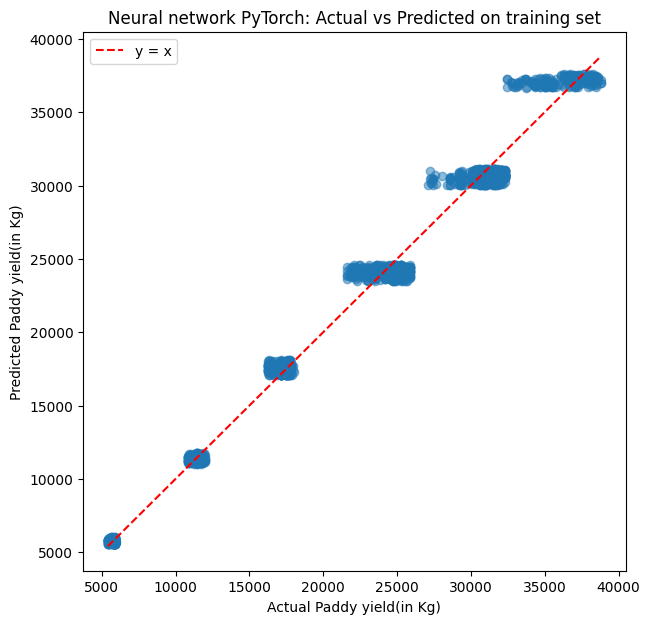

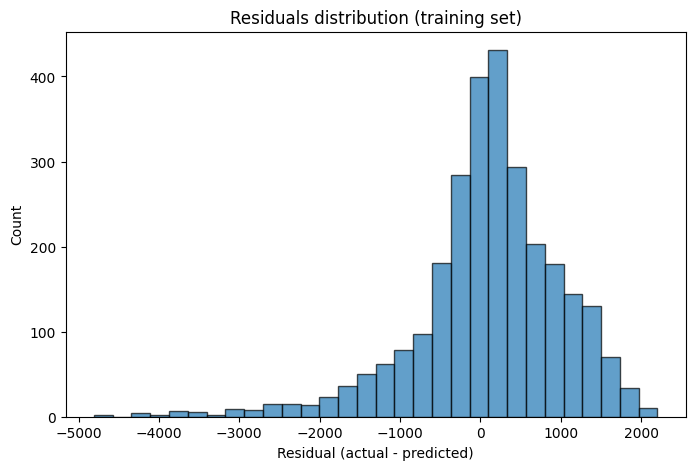

In [20]:
best_nn_model = nn_grid.best_estimator_

# evaluate best model on test set 
X_test = pd.read_csv('../data/X_test')
y_test = pd.read_csv('../data/y_test')

y_pred = best_nn_model.predict(X_test)

r2_test = r2_score(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)

print("Training R^2:", r2_test)
print("Training MSE:", mse_test)
print("Training MAE:", mae_test)

# Actual vs. predicted
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.xlabel("Actual Paddy yield(in Kg)")
plt.ylabel("Predicted Paddy yield(in Kg)")
plt.title("Neural network PyTorch: Actual vs Predicted on test set")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", label="y = x")
plt.legend()
plt.show()

# Residuals histogram
residuals = y_test - y_pred_test
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor="k", alpha=0.7)
plt.xlabel("Residual (actual - predicted)")
plt.ylabel("Count")
plt.title("Residuals distribution (test set)")
plt.show()


Validation R^2: 0.98744797706604
Validation MSE: 1018091.8125
Validation MAE: 714.4967651367188


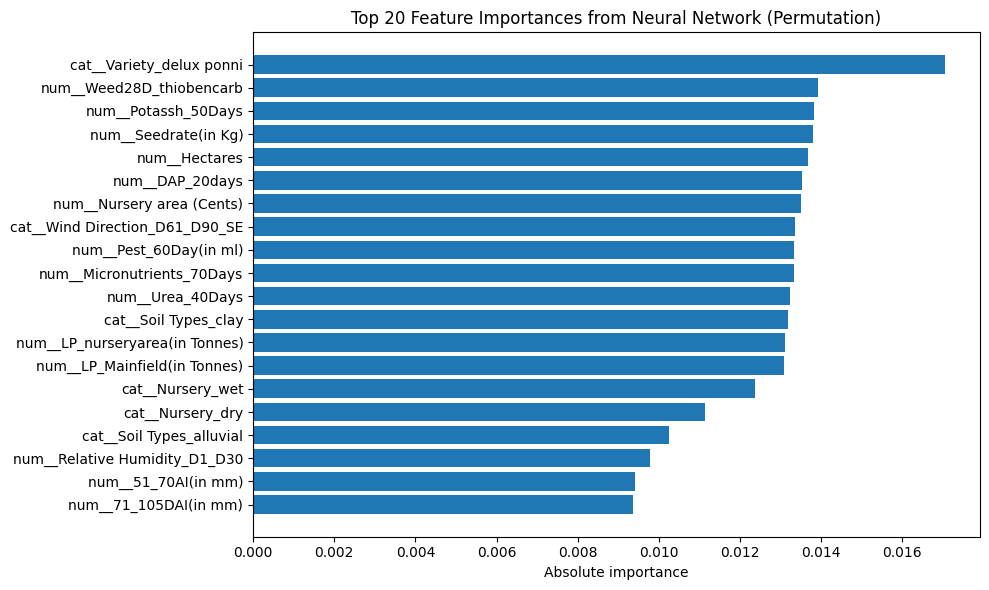

,feature,importance,abs_importance
43,cat__Variety_delux ponni,0.017065,0.017065
6,num__Weed28D_thiobencarb,0.013922,0.013922
8,num__Potassh_50Days,0.013838,0.013838
1,num__Seedrate(in Kg),0.013801,0.013801
0,num__Hectares,0.013674,0.013674
5,num__DAP_20days,0.013542,0.013542
3,num__Nursery area (Cents),0.013499,0.013499
63,cat__Wind Direction_D61_D90_SE,0.013353,0.013353
10,num__Pest_60Day(in ml),0.013340,0.013340
9,num__Micronutrients_70Days,0.013327,0.013327


In [21]:
from sklearn.inspection import permutation_importance

# Split off a validation subset from the training data (no test leakage)
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Refit the best pipeline on the training subset for validation diagnostics
best_nn_model.fit(X_train_sub, y_train_sub)

# Validation metrics
y_pred_val = best_nn_model.predict(X_val_sub)
r2_val = r2_score(y_val_sub, y_pred_val)
mse_val = mean_squared_error(y_val_sub, y_pred_val)
mae_val = mean_absolute_error(y_val_sub, y_pred_val)
print("Validation R^2:", r2_val)
print("Validation MSE:", mse_val)
print("Validation MAE:", mae_val)

# Grab the fitted preprocessing step and the fitted neural net
preprocess_step = best_nn_model.named_steps["preprocess"]
nn_step = best_nn_model.named_steps["nn"]

# Transform the validation features
X_val_transformed = preprocess_step.transform(X_val_sub)

# Compute permutation importance on the neural net using transformed features
perm = permutation_importance(
    nn_step,
    X_val_transformed,
    y_val_sub,
    n_repeats=10,
    scoring="r2",
    random_state=42
)

importances = perm.importances_mean

# Feature names for transformed columns (numeric + one hot encoded)
feature_names = preprocess_step.get_feature_names_out()

# Put into DataFrame (top 20 by absolute importance)
imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances,
    "abs_importance": np.abs(importances),
}).sort_values("abs_importance", ascending=False)

# Plot top 20
top20 = imp_df.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top20["feature"], top20["abs_importance"])
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances from Neural Network (Permutation)")
plt.xlabel("Absolute importance")
plt.tight_layout()
plt.show()

imp_df.head(20)
